In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set your dataset path
data_dir = '/content/drive/MyDrive/dataset'

ModuleNotFoundError: No module named 'google'

In [ ]:
!pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os


In [ ]:
# Normalize using ImageNet values
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir,  transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify final classifier layer
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)  # 2 classes

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 139MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.4709
Epoch [2/5], Loss: 0.2553
Epoch [3/5], Loss: 0.2071
Epoch [4/5], Loss: 0.1744
Epoch [5/5], Loss: 0.1490


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 93.33%


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/densenet121_waste_model.pth')


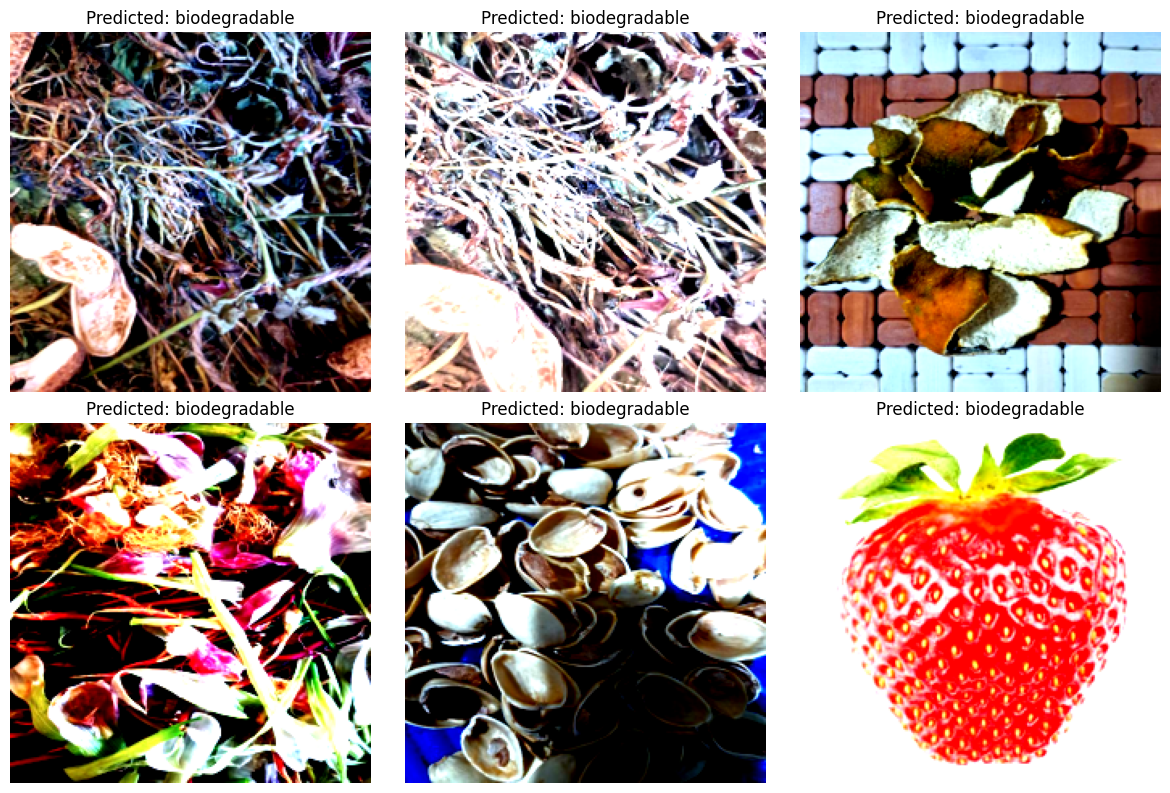

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Utility function to show images
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Evaluate mode
model.eval()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predictions
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Define your class names manually
class_names = ['biodegradable', 'non_biodegradable']

# Plot predictions
plt.figure(figsize=(12, 8))
for i in range(6):  # Show first 6 predictions
    plt.subplot(2, 3, i+1)
    imshow(images[i])
    plt.title(f"Predicted: {class_names[preds[i]]}")
plt.tight_layout()
plt.show()
